### Pretraining Oracle
It is important that we pretrain the critic network before we dive deep into training the actor itself. Let's do exactly that

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import json

cuda = torch.device('cuda')
frame_size = 10 

## WIP!

In [18]:
class StateRepresentation(nn.Module):
    def __init__(self):
        super(StateRepresentation, self).__init__()
        self.lin = nn.Sequential(
            # 128 - embed size, 1 - rating size
            nn.Linear(frame_size * (128 + 1), 256),
            nn.Tanh(),
        )
        
    def forward(self, actions, ratings):
        # raw_size - size of the raw movie info. Constant = 2591
        # embed_size - size of an ebedded movie. Constant = 128
        # raw -> embed via embeddings module defined above
        # input: currently info is batch_size x frame_size x raw_size
        # step 1: tramsform info to batch_size x (frame_size * embed_size)
        actions = actions.view(batch_size, frame_size * 128)
        # step 2: stack info with ratings. stacked: batch_size x (embed_size + 1)
        stacked = torch.cat([actions, ratings], 1)
        # step 3: apply state represemtation module
        state = self.lin(stacked)
        return state

In [19]:
class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.state_rep = StateRepresentation()
        
        # self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear1 = nn.Linear(256 + 128, hidden_size) #state rep + action + rating
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, enc_state, action):
        action = torch.squeeze(action)
        x = torch.cat([enc_state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [26]:
def value_update(batch, 
           gamma = 0.99,
           min_value=-5,
           max_value=5,
           soft_tau=1e-2):
    
    state, action, reward, _, _ = batch

    enc_state = value_net.state_rep(*state)
    value = value_net(enc_state, action)
    value_loss = value_criterion(value, reward)
    
    T_enc_state = target_value_net.state_rep(*state)
    T_value = target_value_net(enc_state, action)
    T_loss = value_criterion(T_value, reward)
    
    value_optimizer.zero_grad()
    value_loss.backward(retain_graph=True)
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    losses = [value_loss.item(), T_loss.item()] 
    return losses

In [27]:
value_net  = Critic(256, 128, 320).to(cuda)
target_value_net  = Critic(256, 128, 320).to(cuda)
for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

value_lr  = 10e-5
value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
value_criterion = nn.MSELoss()

In [28]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='monokai')

def plot(losses, T_losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.title('loss')
    plt.plot(losses, '-b')
    plt.plot(T_losses, '-w')
    plt.show()

In [29]:
batch_bar = tqdm(total=15)

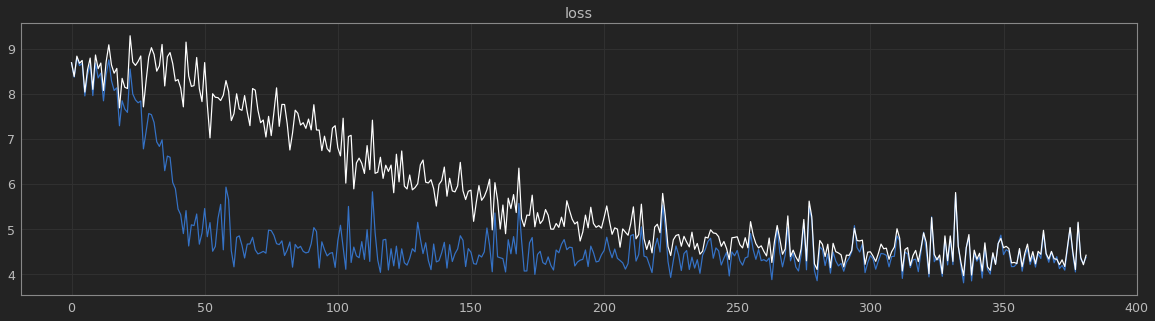

In [ ]:
import time
import torch
import pickle
from tqdm import tqdm_notebook as tqdm
cuda = torch.device('cpu')

def prepare_batch(batch):
    watched_infos = []
    watched_rating = []
    chosen_movie = []
    chosen_rating = []
    next_infos = []
    next_rating = []
    done = []
    
    for b in batch:
        watched_infos.append(b[0][0])
        watched_rating.append(torch.from_numpy(b[0][1]))
        chosen_movie.append(b[1])
        chosen_rating.append(b[2])
        next_infos.append(b[3][0])
        next_rating.append(torch.from_numpy(b[3][1]))
        done.append(b[4])
                    
    watched_infos = torch.stack(watched_infos).to(cuda)
    watched_rating = torch.stack(watched_rating).float().to(cuda)
    chosen_movie = torch.stack(chosen_movie).to(cuda)
    chosen_rating = torch.tensor(chosen_rating).to(cuda)
    next_infos = torch.stack(next_infos).to(cuda)
    next_rating = torch.stack(next_rating).float().to(cuda)
    done = torch.tensor(done).float().to(cuda)
    
    return (watched_infos, watched_rating), chosen_movie, chosen_rating, \
           (next_infos, next_rating), done


batch = []
batch_size = 5000
start = time.time()
losses = []
T_losses = []


#f = pickle.load(open('../data/batches/batch_{}.p'.format(1), 'rb'))

# note change '15' in range(1, 15) to the # of files in your batch folder!
for n_batch in range(1, 15):
    batch_bar.update(1)
    for i in tqdm(f):
        batch.append(i)
        if len(batch) >= batch_size:
            batch = prepare_batch(batch)
            loss = value_update(batch)
            losses.append(loss[0])
            T_losses.append(loss[1])
            batch = []
    plot(losses, T_losses)
end = time.time()

elapsed = end - start
print(elapsed)